Author: [Hasil Sharma](https://github.com/Hasil-Sharma)

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
import re

In [39]:
path = './Data/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'

In [40]:
embed_size = 50 # how big is each word vector
max_features = 6500 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 400 # max number of words in a comment to use

In [41]:
train = pd.read_csv(TRAIN_DATA_FILE)
list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [8]:
train["clean_comment"] = train["comment_text"].apply(lambda x: x.replace('\n', ' '))

In [9]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" More I can't make any real suggestions on im..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"You, sir, are my hero. Any chance you remember..."
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,""" Congratulations from me as well, use the to..."
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,Your vandalism to the Matt Shirvington article...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,Sorry if the word 'nonsense' was offensive to ...
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,alignment on this subject and which are contra...


In [10]:
train[["clean_comment", "identity_hate"]].to_csv("identity_hate_train.csv", index = False)

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

Reference : https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', auc_roc])

In [ ]:
model.

In [17]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {"val_loss" : [], "train_loss": []}

    def on_batch_end(self, batch, logs={}):
        self.losses["train_loss"].append(logs.get('loss'))
        self.losses["val_loss"].append(logs.get('val_loss'))
        
class AccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = {"val_acc" : [], "train_acc": []}

    def on_batch_end(self, batch, logs={}):
        self.acc["train_acc"].append(logs.get('acc'))
        self.acc["val_acc"].append(logs.get('val_acc'))


In [ ]:
loss_history = LossHistory()
acc_history = AccHistory()
history = model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1, callbacks = [loss_history, acc_history]);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143392/143613 [============================>.] - ETA: 12s - loss: 0.0597 - acc: 0.9791 - auc_roc: 0.9357

In [33]:
history.history

{'val_loss': [0.04823996469626855, 0.045795883482404036],
 'val_acc': [0.9821614949068848, 0.982840357911155],
 'val_auc_roc': [0.9709017901122383, 0.9782758309348423],
 'loss': [0.0601732683076678, 0.04451188884458024],
 'acc': [0.97928575438703, 0.9832141338954222],
 'auc_roc': [0.9344468984879765, 0.9757211016609069]}

Text(0,0.5,'loss')

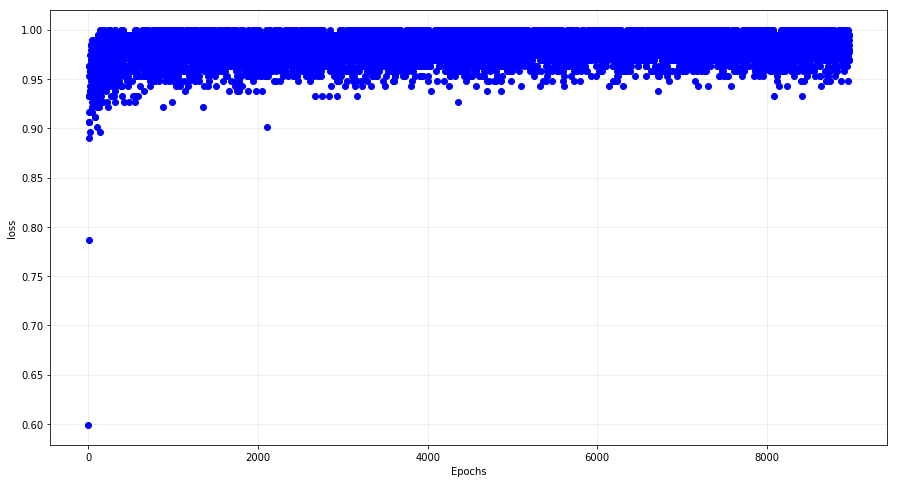

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

ax.plot(acc_history.acc['train_acc'], 'bo')
ax.plot(acc_history.acc['val_acc'], 'ro')
ax.grid(alpha = 0.25)
ax.set_xlabel("Epochs")
ax.set_ylabel("loss")

In [138]:
from keras import backend as K
inp = model.input 

In [139]:
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

In [140]:
layer_outs = [func([temp_input, 1.]) for func in functors]

In [141]:
layer_outs

[[array([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
           34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
           45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
           56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
           67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
           78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
           89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
          100.]], dtype=float32)],
 [array([[[ 0.5199069 ,  0.30844796, -0.21001868, ..., -0.2318563 ,
           -0.2733043 , -0.9383957 ],
          [ 0.6420834 , -0.1127833 ,  0.4272472 , ..., -0.06526023,
            0.00772602, -0.3802694 ],
          [ 0.6989421 ,  0.5031973 , -0.18811023, ..., -0.3470296 ,
 